# Calibrating ensemble models with Logistic Regression

### Logistic regression for calibrating binary classification models (or Platt scaling)

Assuming that we know the predictions of an ensemble model trained to predict a binary variable Y={0,1}, we can train a *Logistic Regression* to predict the same initial binary variable Y={0,1} using the predictions of the ensemble model as the unique feature. Then, the predictions of the *Logistic Regression* will be the calibrated version of the ensemble model predictions.

*Note:* The model is explained in the paper *Handmade_Logistic_Regression.pdf* from the repository *Coding-Machine-Learning-algorithms-from-scratch-in-R* .

\begin{equation} P(Y=1|Prediction) = sigmoid(z) = \frac{1}{1+e^{-z}}=\frac{1}{1+e^{-(w_0+w_1*Prediction)}} \end{equation}

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore")

### Import the ensemble model predictions

Import the *predictions* of the ensemble model and the *true label* (binary in this example) for each observation in a *validation* dataset, not used for training the model.

In [2]:
data = pd.read_excel('Ensemble model predictions in validation dataset.xlsx')
prediction = data["Prediction"]
true_label = data["True_Label"]
data.head()

,True_Label,Prediction
0,0,0.004622
1,0,0.261871
2,1,0.025343
3,0,0.194241
4,0,0.007017


The prediction range of the ensemble model is [0,1] equivalent to the theoretical range of probability for the event Y=1. However, the model is not calibrated as we will see in the following plot because, for example, the bin with predicted value between [0.9-1] has not a 90-100% of positive true labels.

In [3]:
min(prediction), max(prediction)

(2.0520697034953628e-06, 0.9992258548736572)

### Calibrated predictions

Train the *Logistic Regression* model with the predictions of the ensemble model and the true label (binary in this example) for each observation in a *validation* dataset.

In [4]:
x_train = np.reshape(np.array(prediction), (-1,1))
y_train = np.array(true_label)
calibration_model = LogisticRegression()
calibration_model.fit(x_train, y_train,)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [5]:
calibration_model.coef_, calibration_model.intercept_

(array([[3.00095022]]), array([-1.66413995]))

Now compute the calibrated predictions and examine the range of the new calibrated predictions.

In [6]:
calibrated_prediction = calibration_model.predict_proba(x_train)[:,1]
min(calibrated_prediction), max(calibrated_prediction)

(0.15920786410297164, 0.7915818845585993)

### AUC

Examining the AUC we can see how, obviously, it has not changed since the *Logistic Regression* is a linear model and cannot reorder the initial predictions of the ensemble (which is the main thing that the AUC metric evaluates).

In [7]:
from sklearn.metrics import roc_auc_score
roc_auc_score(true_label, prediction), roc_auc_score(true_label, calibrated_prediction) 

(0.7319144435547351, 0.7319144435547351)

### Log Loss

Examining the Log Loss metric we can see how it has been reduced drastically. This metric penalize the error between predicted probability for a label and the real value for a label (0 in case that the observation is negative and 1 if positive), and since the *Logistic Regression* calibrates the ensemble predictions the Log Loss is reduced.

In [8]:
def LogLoss(true_label, prediction):
    return(sum(true_label*np.log(prediction)+(1-true_label)*(1-np.log(prediction)))/prediction.shape[0])

LogLoss(true_label, prediction), LogLoss(true_label, calibrated_prediction)

(3.4399126426896443, 1.712502092970489)

### Bins

For binning the predictions in groups, compute the bins as equally spaced predicted value limits over the range of the predictions.

In [9]:
bins = np.linspace(0, 1, 11)

### % of Y=1 by bins of predictions

In [10]:
bins_prediction = np.array([])
for i in range(0, bins.shape[0]-1):
    indexes = (prediction>bins[i]) & (prediction<=bins[i+1])
    bin_true_label_mean = np.mean(true_label[indexes])
    bins_prediction = np.append(bins_prediction, bin_true_label_mean)
    
bins_prediction

array([0.15599422, 0.28241335, 0.40831296, 0.39130435, 0.41004184,
       0.51075269, 0.50857143, 0.57324841, 0.69135802, 0.72139303])

### % of Y=1 by bins of calibrated predictions

In [11]:
bins_calibrated_prediction = np.array([])
for i in range(0, bins.shape[0]-1):
    indexes = (calibrated_prediction>bins[i]) & (calibrated_prediction<=bins[i+1])
    bin_true_label_mean = np.mean(true_label[indexes])
    bins_calibrated_prediction = np.append(bins_calibrated_prediction, bin_true_label_mean)
    
bins_calibrated_prediction

array([       nan, 0.15387123, 0.31760741, 0.38557214, 0.45578231,
       0.52320675, 0.57939914, 0.71710526,        nan,        nan])

### Let's plot the reliability distributions

In [12]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"

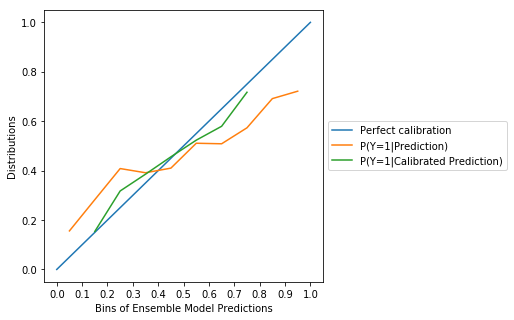

In [13]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label="Perfect calibration")
plt.plot(bins[1:]-0.05, bins_prediction, label='P(Y=1|Prediction)')
plt.plot(bins[1:]-0.05, bins_calibrated_prediction, label='P(Y=1|Calibrated Prediction)')
plt.xticks(bins)
plt.xlabel("Bins of Ensemble Model Predictions")
plt.ylabel("Distributions")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))